In [1]:
import sys
sys.path.insert(0,'..')

import pandas as pd
import numpy as np
import skimage as sk
from skimage import io
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from patchify import patchify, unpatchify

from Util.pyDialogue import askFILE, askFILES, askDIR

import cv2 as cv

import tensorflow as tf
from tensorflow.keras.models import Model, load_model

### TODO
1. Resize and cut image into patches
2. Segment patches
3. Assemble patches  

In [2]:
Image = np.load(askFILE())
print("Image has shape {} and is going to be cut into {} pieces of shape {}.".format(Image[:,:,0].shape, int(np.floor(Image[:,:,0].shape[0]/128)),'(128, 128)'))

Image has shape (2653, 2653) and is going to be cut into 20 pieces of shape (128, 128).


In [3]:
Image_CUT = Image.copy()
Image_CUT = Image_CUT[:-(Image_CUT.shape[0] % 128), :-(Image_CUT.shape[1] % 128), :]

In [4]:
Patches = patchify(Image_CUT[:,:,0], (128,128), 128)

In [5]:
Predictor = load_model(askFILE())

In [7]:
Data_In = np.reshape(Patches,(400,128,128))
Data_In = Data_In/255
Data_In = Data_In.astype('float32')

In [8]:
Data_MASK = Predictor.predict(Data_In)

In [9]:
Data_MASK.shape

(400, 128, 128, 3)

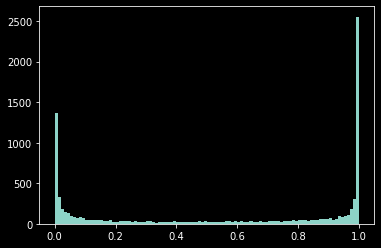

In [18]:
HIST = plt.hist(np.unique(Data_MASK[11,:,:,0]), bins=100)

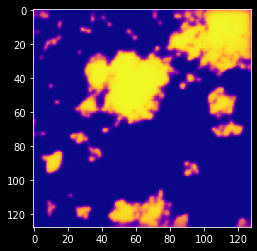

In [13]:
plt.imshow(Data_MASK[11,:,:,2], cmap='plasma')

### Thresholding notes
#### LNP Mask
- >= 0.5 -> border artifacts vanish
- >= 0.6 -> MICRO artifacts start to vanish
- >= 0.8 -> MICRO artifacts almost complete vanish

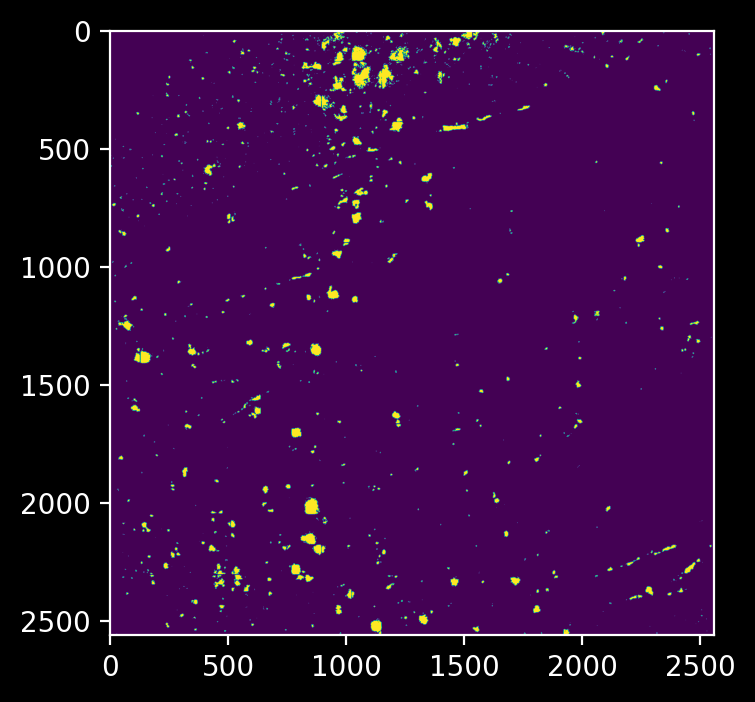

In [36]:
plt.figure(figsize = (8,4), dpi = 200)
plt.imshow(unpatchify(np.reshape(Data_MASK[:,:,:,2]>=0.80, (20,20,128,128)), Image_CUT[:,:,0].shape))

In [10]:
image = cv.imread(askFILE())

In [7]:
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

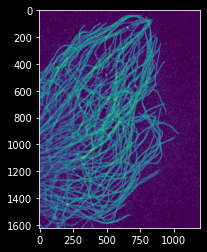

In [9]:
plt.imshow(image)

In [2]:
def Segment(Image, Patchsize, Predictor):
        
    Image_CUT = Image.copy()
    Image_CUT = Image_CUT[:-(Image_CUT.shape[0] % Patchsize), :-(Image_CUT.shape[1] % Patchsize), :]
    
    NumImg = (np.floor(Image_CUT[:,:,0].shape[0]/Patchsize))
    NumImg_tmp = int(np.floor(NumImg**2))
    
    print("Image has shape {} and is going to be cut into {} pieces of shape {}.".format(Image[:,:,0].shape, int(NumImg),(Patchsize,Patchsize)))
    
    Patches = patchify(Image_CUT[:,:,0], (Patchsize,Patchsize), Patchsize)
    Data_In = np.reshape(Patches,(NumImg_tmp,Patchsize,Patchsize))
    Data_In = Data_In/255
    Data_In = Data_In.astype('float32')
    Data_MASK = Predictor.predict(Data_In)
    
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize = (10,5), dpi = 200)
    
    plt.style.use('dark_background')
    plt.subplots_adjust(wspace=0.3)
    
    ax1.axis('off')
    ax1.set_title('Vanilla Image')
    im1 = ax1.imshow(Image_CUT[:,:,0], cmap = 'gray')
    plt.colorbar(im1, ax = ax1)
    
    ax2.axis('off')
    ax2.set_title('Segmentation Mask MICRO')
    im2 = ax2.imshow(unpatchify(np.reshape(Data_MASK[:,:,:,1]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape), cmap = 'plasma')
    plt.colorbar(im2, ax = ax2)

    ax3.axis('off')
    ax3.set_title('Segmentation Mask LNP')
    im3 = ax3.imshow(unpatchify(np.reshape(Data_MASK[:,:,:,2]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape), cmap = 'plasma')
    plt.colorbar(im3, ax = ax3)
    
    ####################################################################

    ax4.axis('off')
    ax4.set_title('Segmented Background')
    im4 = ax4.imshow((unpatchify(np.reshape(Data_MASK[:,:,:,0]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape))*Image_CUT[:,:,0], cmap = 'gray')
    plt.colorbar(im4, ax = ax4)
    
    ax5.axis('off')
    ax5.set_title('Segmented Microtubules')
    im5 = ax5.imshow((unpatchify(np.reshape(Data_MASK[:,:,:,1]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape))*Image_CUT[:,:,0], cmap = 'gray')
    plt.colorbar(im5, ax = ax5)
    
    ax6.axis('off')
    ax6.set_title('Segmented LNPs')
    im6 = ax6.imshow((unpatchify(np.reshape(Data_MASK[:,:,:,2]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape))*Image_CUT[:,:,0], cmap = 'gray')
    plt.colorbar(im6, ax = ax6)

In [2]:
def Segment_WB(Image, Patchsize, Predictor):
        
    Image_CUT = Image.copy()
    Image_CUT = Image_CUT[:-(Image_CUT.shape[0] % Patchsize), :-(Image_CUT.shape[1] % Patchsize)]
    
    NumImg = (np.floor(Image_CUT.shape[0]/Patchsize))
    NumImg_tmp = int(np.floor(NumImg**2))
    

    
    print("Image has shape {} and is going to be cut into {} pieces of shape {}.".format(Image.shape, int(NumImg),(Patchsize,Patchsize)))
    
    Patches = patchify(Image_CUT, (Patchsize,Patchsize), Patchsize)
    Data_In = np.reshape(Patches,(NumImg_tmp,Patchsize,Patchsize))
    Data_In = Data_In/255
    Data_In = Data_In.astype('float32')
    Data_MASK = Predictor.predict(Data_In)
    
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize = (10,5), dpi = 200)
    
    plt.style.use('dark_background')
    plt.subplots_adjust(wspace=0.3)
    
    ax1.axis('off')
    ax1.set_title('Vanilla Image')
    im1 = ax1.imshow(Image_CUT, cmap = 'gray')
    plt.colorbar(im1, ax = ax1)
    
    ax2.axis('off')
    ax2.set_title('Segmentation Mask MICRO')
    im2 = ax2.imshow(unpatchify(np.reshape(Data_MASK[:,:,:,1]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:].shape), cmap = 'plasma')
    plt.colorbar(im2, ax = ax2)

    ax3.axis('off')
    ax3.set_title('Segmentation Mask LNP')
    im3 = ax3.imshow(unpatchify(np.reshape(Data_MASK[:,:,:,2]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:].shape), cmap = 'plasma')
    plt.colorbar(im3, ax = ax3)
    
    ####################################################################

    ax4.axis('off')
    ax4.set_title('Segmented Background')
    im4 = ax4.imshow((unpatchify(np.reshape(Data_MASK[:,:,:,0]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:].shape))*Image_CUT[:,:], cmap = 'gray')
    plt.colorbar(im4, ax = ax4)
    
    ax5.axis('off')
    ax5.set_title('Segmented Microtubules')
    im5 = ax5.imshow((unpatchify(np.reshape(Data_MASK[:,:,:,1]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:].shape))*Image_CUT[:,:], cmap = 'gray')
    plt.colorbar(im5, ax = ax5)
    
    ax6.axis('off')
    ax6.set_title('Segmented LNPs')
    im6 = ax6.imshow((unpatchify(np.reshape(Data_MASK[:,:,:,2]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:].shape))*Image_CUT[:,:], cmap = 'gray')
    plt.colorbar(im6, ax = ax6)

In [7]:
def Segment_ACTIN(Image, Patchsize, Predictor):
        
    Image_CUT = Image.copy()
    Image_CUT = Image_CUT[:-(Image_CUT.shape[0] % Patchsize), :-(Image_CUT.shape[1] % Patchsize), :]
    
    NumImg = (np.floor(Image_CUT[:,:,0].shape[0]/Patchsize))
    NumImg_tmp = int(np.floor(NumImg**2))
    
    print("Image has shape {} and is going to be cut into {} pieces of shape {}.".format(Image[:,:,0].shape, int(NumImg),(Patchsize,Patchsize)))
    
    Patches = patchify(Image_CUT[:,:,0], (Patchsize,Patchsize), Patchsize)
    Data_In = np.reshape(Patches,(NumImg_tmp,Patchsize,Patchsize))
    Data_In = Data_In/255
    Data_In = Data_In.astype('float32')
    Data_MASK = Predictor.predict(Data_In)
    
    fig, ((ax1,ax2,ax3,ax7),(ax4,ax5,ax6,ax8)) = plt.subplots(2,4,figsize = (10,5), dpi = 200)
    
    plt.style.use('dark_background')
    plt.subplots_adjust(wspace=0.3)
    
    ax1.axis('off')
    ax1.set_title('Vanilla Image')
    im1 = ax1.imshow(Image_CUT[:,:,0], cmap = 'gray')
    plt.colorbar(im1, ax = ax1)
    
    ax2.axis('off')
    ax2.set_title('Segmentation Mask MICRO')
    im2 = ax2.imshow(unpatchify(np.reshape(Data_MASK[:,:,:,1]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape), cmap = 'plasma')
    plt.colorbar(im2, ax = ax2)

    ax3.axis('off')
    ax3.set_title('Segmentation Mask LNP')
    im3 = ax3.imshow(unpatchify(np.reshape(Data_MASK[:,:,:,2]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape), cmap = 'plasma')
    plt.colorbar(im3, ax = ax3)
    
    ax7.axis('off')
    ax7.set_title('Segmentation Mask ACTIN')
    im7 = ax7.imshow(unpatchify(np.reshape(Data_MASK[:,:,:,3]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape), cmap = 'plasma')
    plt.colorbar(im7, ax = ax7)
    
    ####################################################################

    ax4.axis('off')
    ax4.set_title('Segmented Background')
    im4 = ax4.imshow((unpatchify(np.reshape(Data_MASK[:,:,:,0]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape))*Image_CUT[:,:,0], cmap = 'gray')
    plt.colorbar(im4, ax = ax4)
    
    ax5.axis('off')
    ax5.set_title('Segmented Microtubules')
    im5 = ax5.imshow((unpatchify(np.reshape(Data_MASK[:,:,:,1]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape))*Image_CUT[:,:,0], cmap = 'gray')
    plt.colorbar(im5, ax = ax5)
    
    ax6.axis('off')
    ax6.set_title('Segmented LNPs')
    im6 = ax6.imshow((unpatchify(np.reshape(Data_MASK[:,:,:,2]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape))*Image_CUT[:,:,0], cmap = 'gray')
    plt.colorbar(im6, ax = ax6)
    
    ax8.axis('off')
    ax8.set_title('Segmented Actin')
    im8 = ax8.imshow((unpatchify(np.reshape(Data_MASK[:,:,:,3]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape))*Image_CUT[:,:,0], cmap = 'gray')
    plt.colorbar(im8, ax = ax8)

In [3]:
def Segment_MIC_ACT(Image, Patchsize, Predictor):
        
    Image_CUT = Image.copy()
    Image_CUT = Image_CUT[:-(Image_CUT.shape[0] % Patchsize), :-(Image_CUT.shape[1] % Patchsize), :]
    
    NumImg = (np.floor(Image_CUT[:,:,0].shape[0]/Patchsize))
    NumImg_tmp = int(np.floor(NumImg**2))
    
    print("Image has shape {} and is going to be cut into {} pieces of shape {}.".format(Image[:,:,0].shape, int(NumImg),(Patchsize,Patchsize)))
    
    Patches = patchify(Image_CUT[:,:,0], (Patchsize,Patchsize), Patchsize)
    Data_In = np.reshape(Patches,(NumImg_tmp,Patchsize,Patchsize))
    Data_In = Data_In/255
    Data_In = Data_In.astype('float32')
    Data_MASK = Predictor.predict(Data_In)
    
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize = (10,5), dpi = 200)
    
    plt.style.use('dark_background')
    plt.subplots_adjust(wspace=0.3)
    
    ax1.axis('off')
    ax1.set_title('Vanilla Image')
    im1 = ax1.imshow(Image_CUT[:,:,0], cmap = 'gray')
    plt.colorbar(im1, ax = ax1)
    
    ax2.axis('off')
    ax2.set_title('Segmentation Mask MICRO')
    im2 = ax2.imshow(unpatchify(np.reshape(Data_MASK[:,:,:,1]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape), cmap = 'plasma')
    plt.colorbar(im2, ax = ax2)

    ax3.axis('off')
    ax3.set_title('Segmentation Mask ACTIN')
    im3 = ax3.imshow(unpatchify(np.reshape(Data_MASK[:,:,:,2]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape), cmap = 'plasma')
    plt.colorbar(im3, ax = ax3)
    
    ####################################################################

    ax4.axis('off')
    ax4.set_title('Segmented Background')
    im4 = ax4.imshow((unpatchify(np.reshape(Data_MASK[:,:,:,0]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape))*Image_CUT[:,:,0], cmap = 'gray')
    plt.colorbar(im4, ax = ax4)
    
    ax5.axis('off')
    ax5.set_title('Segmented Microtubules')
    im5 = ax5.imshow((unpatchify(np.reshape(Data_MASK[:,:,:,1]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape))*Image_CUT[:,:,0], cmap = 'gray')
    plt.colorbar(im5, ax = ax5)
    
    ax6.axis('off')
    ax6.set_title('Segmented Actin')
    im6 = ax6.imshow((unpatchify(np.reshape(Data_MASK[:,:,:,2]>=0.80, (int(NumImg),int(NumImg),Patchsize,Patchsize)), Image_CUT[:,:,0].shape))*Image_CUT[:,:,0], cmap = 'gray')
    plt.colorbar(im6, ax = ax6)

In [3]:
#Image = np.load(askFILE())
#Image = cv.imread(askFILE())
Predictor = load_model(askFILE())

In [4]:
Image = np.load(askFILE())

In [6]:
import cv2 as cv
Image = cv.imread(askFILE())

Image has shape (2500, 2500) and is going to be cut into 9 pieces of shape (256, 256).


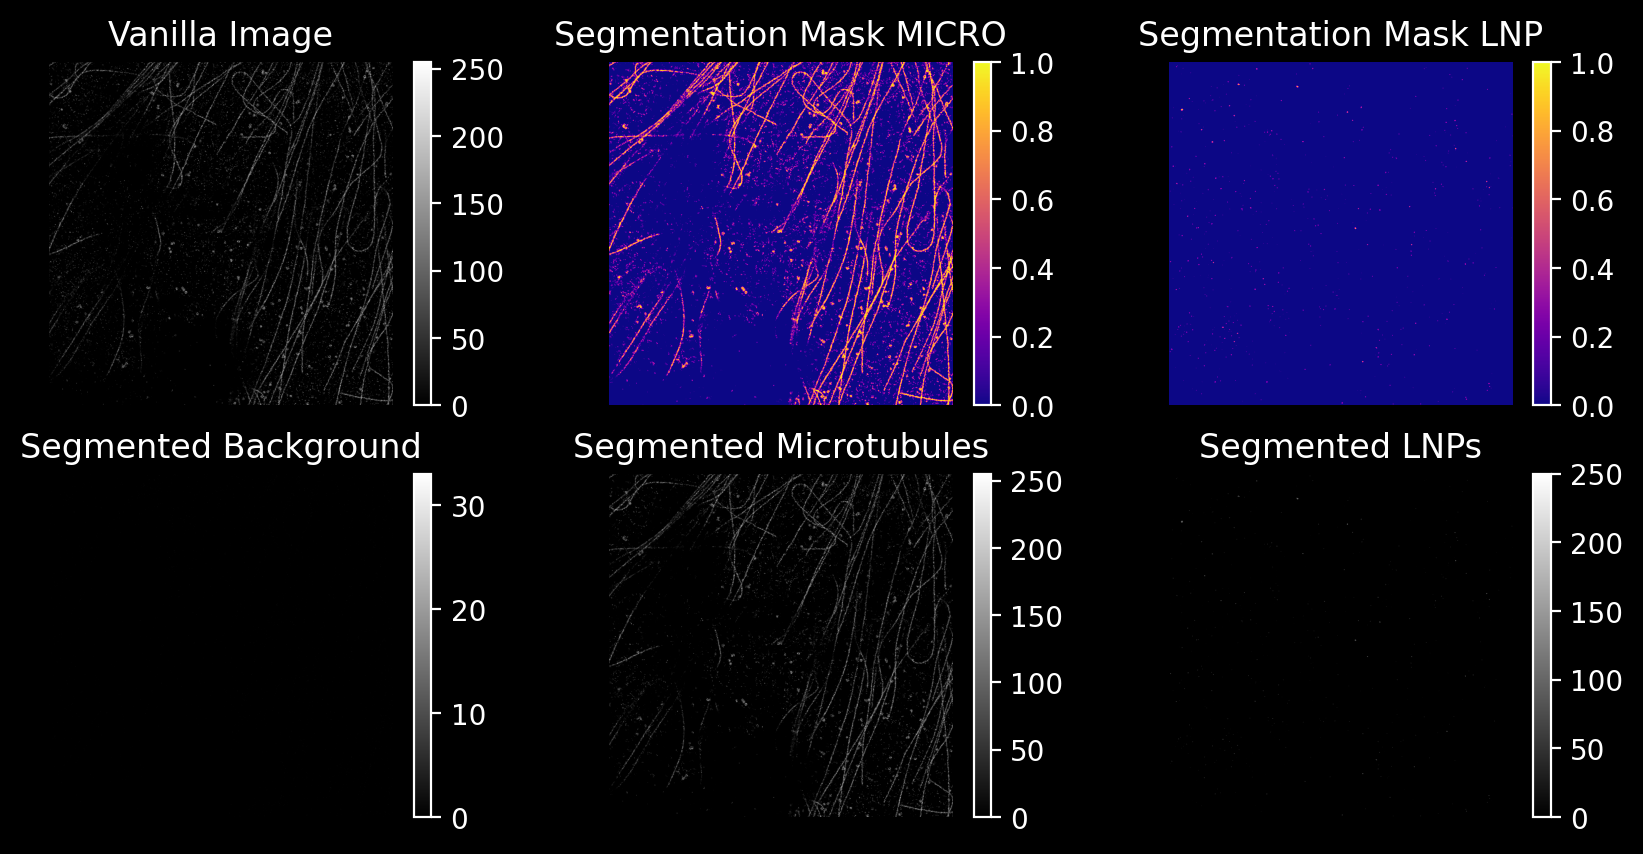

In [5]:
Segment_WB(Image=Image[:2500,:2500], Predictor=Predictor, Patchsize=int(256))

In [37]:
Image.shape[0]/256

13.0

In [34]:
(Image.shape[0] % 256)

0

In [32]:
I_CUT.shape[0]

0

In [28]:
I_CUT[:-(I_CUT.shape[0] % 256), :-(I_CUT.shape[1] % 256)]

array([], shape=(0, 0), dtype=float64)

Image has shape (3782, 3782) and is going to be cut into 29 pieces of shape (128, 128).


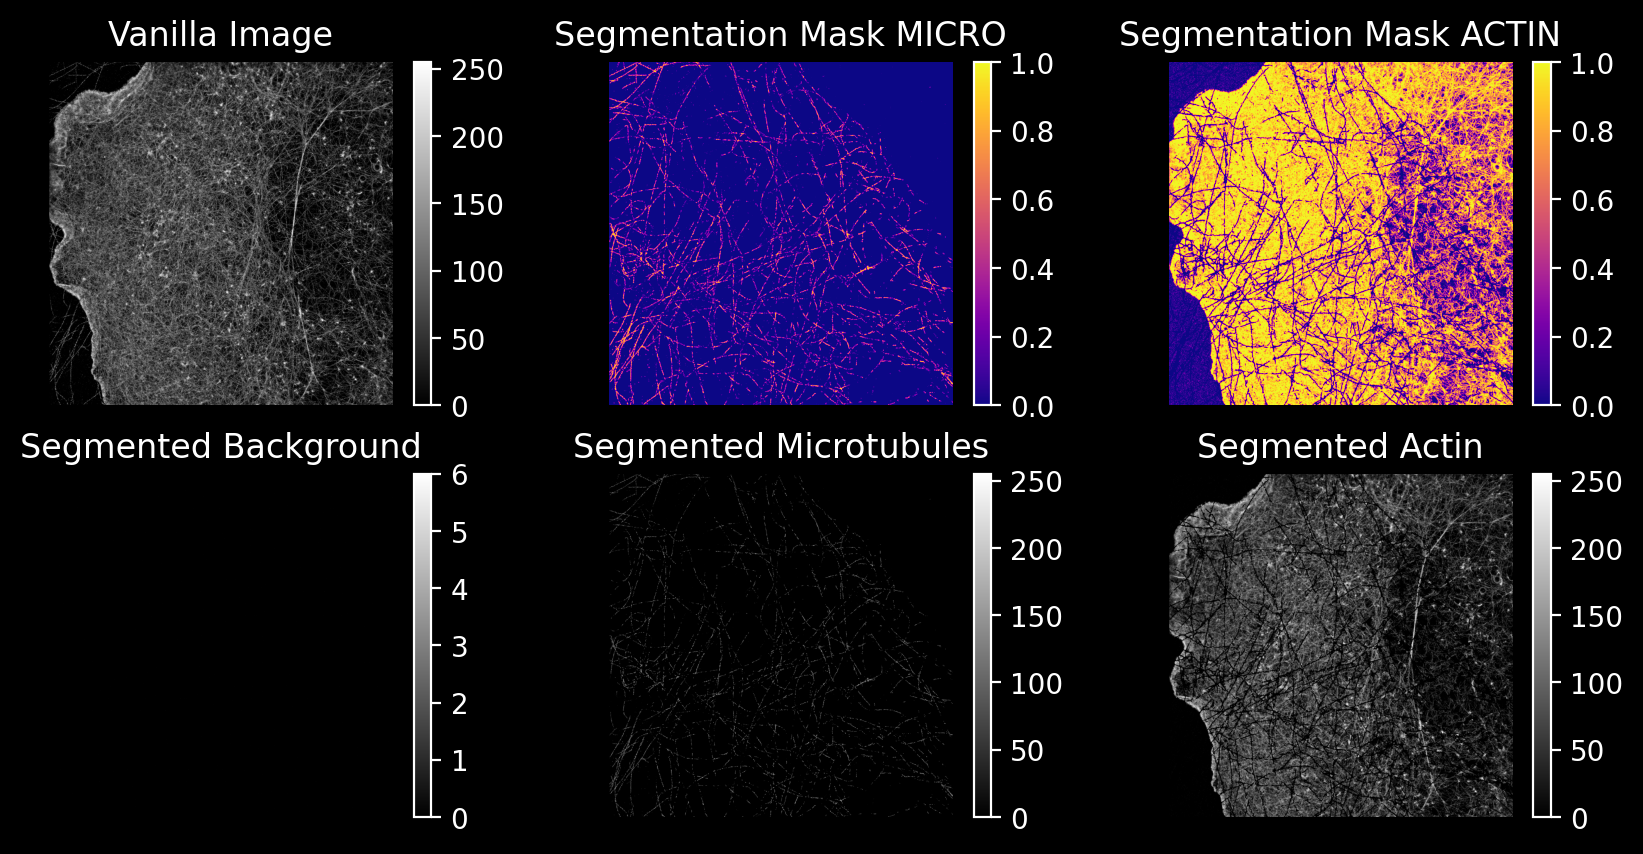

In [12]:
Segment_MIC_ACT(Image=Image, Predictor=Predictor, Patchsize=int(128))

Image has shape (3743, 3796) and is going to be cut into 9 pieces of shape (384, 384).


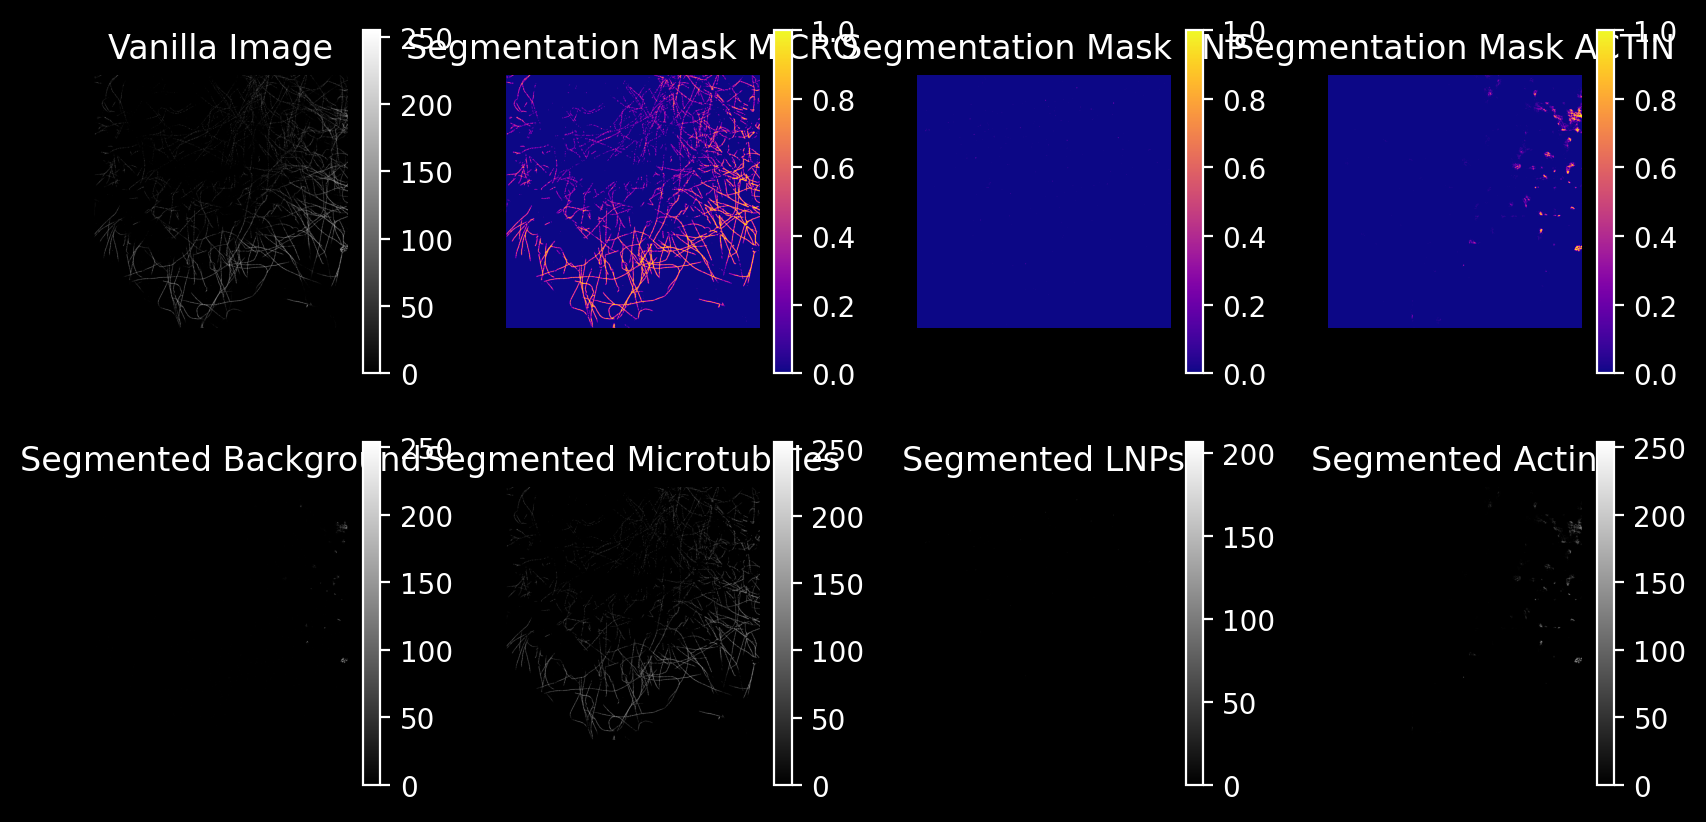

In [13]:
Segment_ACTIN(Image=Image, Predictor=Predictor, Patchsize=int(384))

Image has shape (3801, 3781) and is going to be cut into 14 pieces of shape (256, 256).


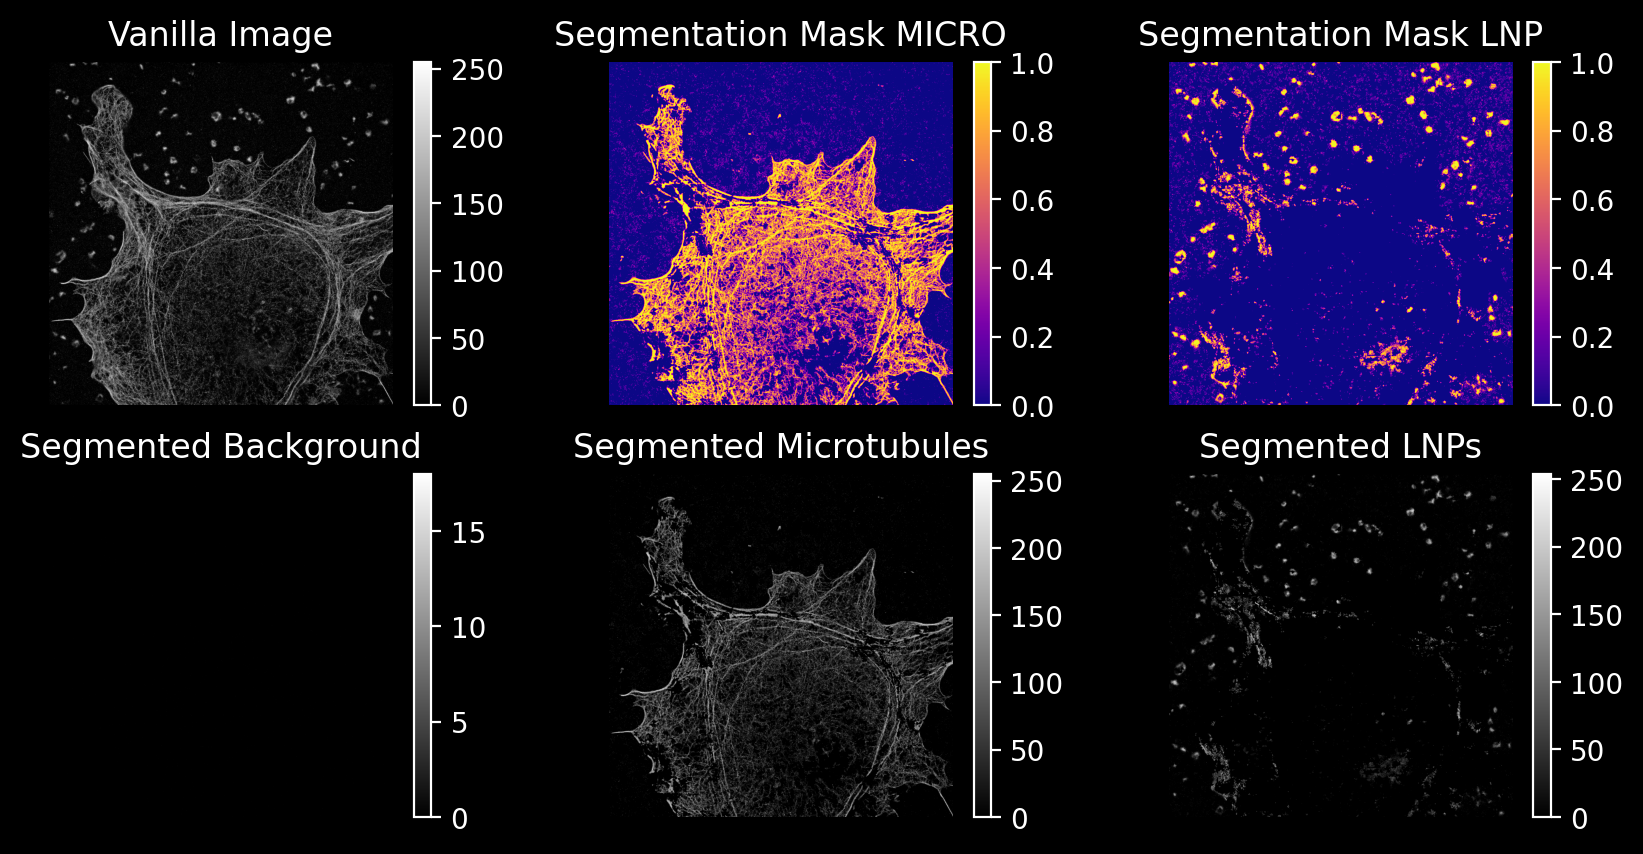

In [30]:
Segment(Image=Image, Predictor=Predictor, Patchsize=int(256))

In [4]:
from tensorflow.keras.utils import plot_model

In [5]:
plot_model(Predictor,
            to_file="UnetMODEL.png",
            show_shapes=False,
            show_dtype=False,
            show_layer_names=True,
            rankdir="TB",
            expand_nested=False,
            dpi=96,
            layer_range=None,
            show_layer_activations=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
